<a href="https://colab.research.google.com/github/AsmitaWaghmare024/Asmita024/blob/main/AngryBird.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import statistics
import random
import cv2
import numpy as np

In [ ]:
def ReinforcementLearning(data, s="s", a="a", r="r", s_new="s_new", learningRule="experienceReplay", iter=2,
                          control={"alpha": 0.1, "gamma": 0.1, "epsilon": 0.1}, verbose=False, model=None,policy_type='best', **kwargs):

    if not (iter > 0 and isinstance(iter, int) and iter == int(iter)):
        raise ValueError("Argument 'iter' should be an integer > 0.")

    if model is not None and not isinstance(model, dict):
        raise ValueError("Argument 'model' must be empty or a dictionary.")

    if not isinstance(control, dict):
        raise ValueError("Argument 'control' must be a dictionary.")

    if "alpha" not in control or "gamma" not in control or not all(isinstance(val, (int, float)) for val in control.values()):
        raise ValueError("Missing or invalid control parameters.")

    if any(val > 1 or val < 0 for val in control.values()):
        raise ValueError("Control parameter values must be between 0 and 1.")

    if not isinstance(data, pd.DataFrame):
        raise ValueError("Argument 'data' must be a pandas DataFrame.")

    if isinstance(data, pd.DataFrame) and "tbl" in str(type(data)):
        data = data.copy()

    if not all(isinstance(arg, str) for arg in [s, a, r, s_new]):
        raise ValueError("Arguments 's', 'a', 'r', and 's_new' must be of type 'str'.")

    if set(['s', 'a', 'r', 's_new']).issubset(data.columns):
        raise ValueError("Data columns invalid or not provided.")

    else :
      data_new = data.copy()
      data_new = data_new.rename(columns={'State':'s','Action':'a',"Reward":'r',
                                            'NextState':'s_new'})
      d = data_new[['s', 'a', 'r', 's_new']].copy()
      d.columns = ['s', 'a', 'r', 's_new']

    if  all(isinstance(d['s'], str) and isinstance(d['a'], str) and isinstance(d['s_new'], str) and isinstance(d['r'], (int, float)) for _ in d.iterrows()):
        raise ValueError("Input data invalid. States and actions must be of type 'str', while rewards must be of type 'numeric'.")

    if d['r'].isnull().values.any():
        raise ValueError("Input data invalid. Reward column contains NA values.")

    Q = defaultdict(lambda: defaultdict(lambda: 0))
    rewardSequence = []

    for i in d['s'].unique():
        if i not in Q:
            Q[i] = defaultdict(lambda: 0, {a: 0 for a in d['a'].unique()})

    agentFunction = lookupLearningRule(learningRule)

    knowledge = {"Q": Q}
    learned = {}

    for i in range(1, iter+1):
        if verbose:
            print("Iteration:", i, "/", iter)
        learned[i] = agentFunction(d, knowledge["Q"], control)
        knowledge = learned[i]

    out = {}
    out["Q_hash"] = learned[iter]["Q"]
    out["Q"] = {state: dict(values) for state, values in learned[iter]["Q"].items()}
    out["States"] = list(out["Q"].keys())
    out["Actions"] = list(out["Q"][out["States"][0]].keys())
    out["Policy"] = computePolicy(out["Q"],policy_type)
    out["LearningRule"] = learningRule
    out["Reward"] = sum(d['r'])
    out["RewardSequence"] = rewardSequence + [sum(d['r'])] * iter

    return out

In [ ]:
def print_rl(x):
    print("State-Action function Q")
    print(x["Q"])
    print("\nPolicy")
    print(x["Policy"])
    print("\nReward (last iteration)")
    print(x["Reward"])

In [ ]:
def summary_rl(object):
    print("\nModel details")
    print("Learning rule:           ", object["LearningRule"])
    print("Learning iterations:     ", len(object["RewardSequence"]))
    print("Number of states:        ", len(object["Q"]))
    print("Number of actions:       ", len(object["Q"][object["States"][0]]))
    print("Total Reward:            ", object["Reward"])

    print("\nReward details (per iteration)")
    rewardSequence = object["RewardSequence"]
    print("Min:                     ", min(rewardSequence))
    print("Max:                     ", max(rewardSequence))
    print("Average:                 ", sum(rewardSequence) / len(rewardSequence))
    print("Median:                  ", statistics.median(rewardSequence))
    print("Standard deviation:      ", statistics.stdev(rewardSequence))

In [ ]:
def predict_rl(Q, newdata=None):

    if newdata is None:
        return computePolicy(Q, policy_type='best')

    if not isinstance(newdata, list):
        raise ValueError("Argument 'newdata' must be a list.")

    p = computePolicy(Q, policy_type='best')

    for state in newdata:

        if state not in p:
            raise ValueError("Invalid state in argument 'newdata'.")

    out = [p[state] for state in newdata]

    return out

In [ ]:
def plot_rl(x, type="o", xlab="Learning iteration", ylab="Reward", main="Reinforcement learning curve", **kwargs):
    plt.plot(range(1, len(x["RewardSequence"]) + 1), x["RewardSequence"], type)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(main)
    plt.show()

In [ ]:
def replayExperience(D, Q, control, **kwargs):
    for _, row in D.iterrows():
        state = row["s"]
        action = row["a"]
        reward = row["r"]
        nextState = row["s_new"]

        currentQ = Q[state][action]

        maxNextQ = max(Q[nextState].values()) if nextState in Q else 0
        Q[state][action] = currentQ + control["alpha"] * (reward + control["gamma"] * maxNextQ - currentQ)

    return {"Q": Q}

In [ ]:
def lookupLearningRule(learningRule):
    if learningRule == "experienceReplay":
        return replayExperience

    raise ValueError("Name of learning rule not recognized. Corresponding argument has an invalid value.")


In [ ]:
def computePolicy(x, policy_type='best'):
    if isinstance(x, dict):
        Q = x
    elif isinstance(x, pd.DataFrame):
        Q = x.to_dict()
    elif hasattr(x, 'Q_hash'):
        Q = x.Q_hash
    else:
        raise ValueError("Argument 'x' must be a dictionary, pandas DataFrame, or rl object.")

    if policy_type == 'best':
        policy = {}
        for state, actions in Q.items():
            best_action = max(actions, key=actions.get)  # Get action with highest Q-value
            policy[state] = best_action

    elif policy_type == 'average':
        policy = {}
        for state, actions in Q.items():
            best_action = max(actions, key=actions.get)  # Get action with highest Q-value
            worst_action = min(actions, key=actions.get)  # Get action with lowest Q-value
            avg_policy = {}
            for action in actions.keys():
                avg_policy[action] = (Q[state][best_action] + Q[state][worst_action]) / 2  # Compute average Q-value
            policy[state] = max(avg_policy, key=avg_policy.get)  # Choose action with highest average Q-value

    elif policy_type == 'worst':
        policy = {}
        for state, actions in Q.items():
            worst_action = min(actions, key=actions.get)  # Get action with lowest Q-value
            policy[state] = worst_action
    else:
        raise ValueError("Invalid policy type. Available types are 'best', 'worst', 'random', and 'average'.")

    return policy

In [ ]:
def state(x, storeObject=False, **kwargs):
    if isinstance(x, str):
        return x
    elif isinstance(x, (int, float)):
        return str(x)
    else:
        return str(x)

In [ ]:
def identify_objects(image_path):
    # Load the image
    image = cv2.imread(image_path)
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply edge detection
    edges = cv2.Canny(gray, 50, 150)
    # Find contours in the edge-detected image
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    bird_contour = None
    target_contour = None

    for contour in contours:
        # Approximate the contour to reduce the number of points
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)

        # Check if the contour is a bird (assuming a bird has 3 vertices)
        if len(approx) == 3:
            bird_contour = contour
        # Check if the contour is a target (assuming a target has 4 vertices)
        elif len(approx) == 4:
            target_contour = contour
    #print(bird_contour)

    return bird_contour, target_contour

In [ ]:
def create_grid_environment(bird_contour, target_contour, grid_size=(5,5), cell_size=100):
    grid = np.zeros(grid_size)

    bird_position = (0, 3)  # Default position at center of the grid
    target_position = (4, 4)  # Default position at bottom right corner of the grid

    if bird_contour is not None :
      bird_position = (int(bird_contour[0][0][0] / cell_size), int(bird_contour[0][0][1] / cell_size))
    # Ensure bird position is within the grid boundaries
      bird_position = (min(max(bird_position[0], 0), grid_size[1] - 1), min(max(bird_position[1], 0), grid_size[0] - 1))

    if target_contour is not None :
      target_position = (int(target_contour[0][0][0] / cell_size), int(target_contour[0][0][1] / cell_size))
    # Ensure target position is within the grid boundaries
      target_position = (min(max(target_position[0], 0), grid_size[1] - 1), min(max(target_position[1], 0), grid_size[0] - 1))

    grid[bird_position[1], bird_position[0]] = 1  # Bird represented by 1
    grid[target_position[1], target_position[0]] = 2  # Target represented by 2

    return grid

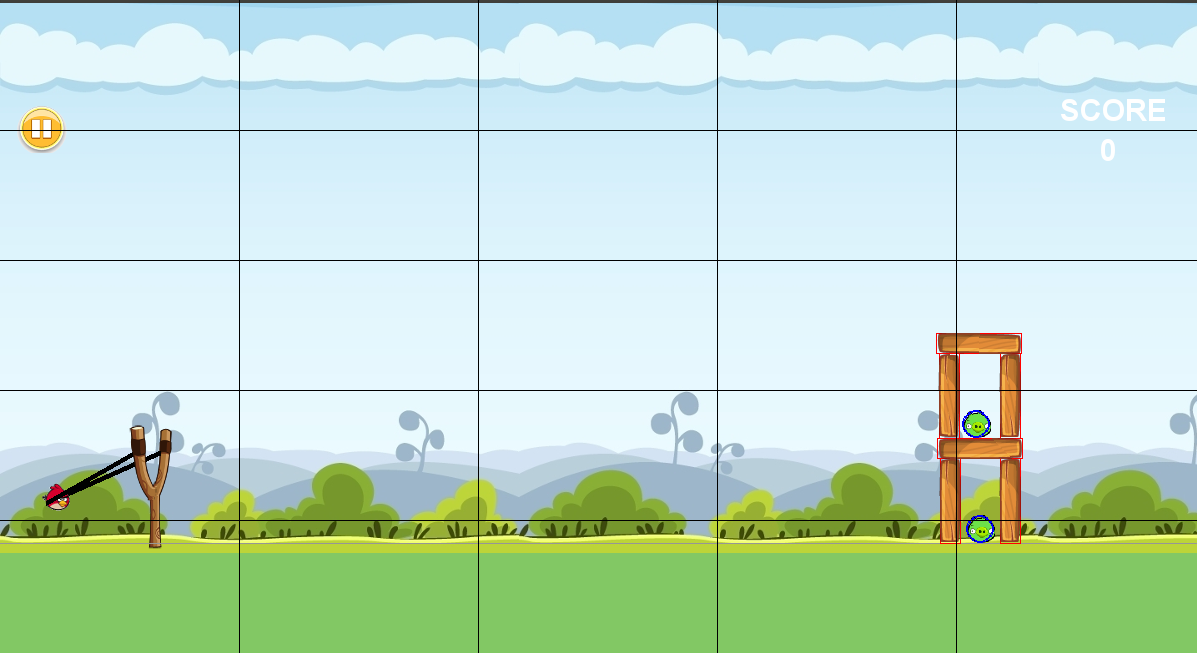

In [ ]:
bird_contour, target_contour = identify_objects("/angry-birds-image.png")

from google.colab.patches import cv2_imshow

def overlay_image_with_grid(image_path, grid):
    # Load the image
    image = cv2.imread(image_path)

    # Calculate the dimensions of each cell in the grid based on the image size and grid size
    cell_width = image.shape[1] // grid.shape[1]
    cell_height = image.shape[0] // grid.shape[0]

    # Draw grid lines on the image
    for i in range(1, grid.shape[1]):
        x = i * cell_width
        cv2.line(image, (x, 0), (x, image.shape[0]), (0, 0, 0), 1)  # Draw vertical line

    for i in range(1, grid.shape[0]):
        y = i * cell_height
        cv2.line(image, (0, y), (image.shape[1], y), (0,0,0), 1)  # Draw horizontal line

    # Overlay the grid on the image
    overlay = image.copy()
    alpha = 0.5  # Opacity of the grid overlay
    cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0, image)

    return image

grid = create_grid_environment(bird_contour, target_contour)
overlayed_image = overlay_image_with_grid("/angry-birds-image.png", grid)
cv2_imshow(overlayed_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
def gridworldEnvironment(state, action, grid):
    next_state = state
    reward = 0

    # Find the positions of the bird and target in the grid
    bird_position = np.argwhere(grid == 1)[0] if np.any(grid == 1) else None
    target_position = np.argwhere(grid == 2)[0] if np.any(grid == 2) else None

    #print(bird_position)
    #print(target_position)

    if action == "move_down_right":
            bird_position[0] += 1
            bird_position[1] += 2
    elif action == "move_down_left":
            bird_position[0] += 1
            bird_position[1] -= 1
    elif action == "move_up_right":
            bird_position[0] -= 1
            bird_position[1] += 1
    elif action == "move_up_left":
            bird_position[0] -= 1
            bird_position[1] -= 1
    elif action == 'straight' :
            bird_position[0] = bird_position[0]
            bird_position[1] += 2

    if (target_position[0] - 1 < bird_position[0] <= target_position[0] + 1) or  \
           (target_position[1] - 1 < bird_position[1] <= target_position[1] + 1):
            next_state = "hit_target"
            reward = 1
    else:
            next_state = "continue"
            reward = -1

    return {"NextState": next_state, "Reward": reward}

In [ ]:
def sampleGridSequence(N, actionSelection="random",
                       control={"alpha": 0.1, "gamma": 0.1, "epsilon": 0.1},
                       model=None):

    states = ["hit_target", "continue"]
    actions = ["move_down_right","move_down_left","move_up_right","move_up_left","straight"]
    action_selection = actionSelection
    data = pd.DataFrame()
    grid = create_grid_environment(bird_contour, target_contour)


    data = sample_experience(N=N, env=gridworldEnvironment, states=states, actions=actions, grid=grid,
                           action_selection=action_selection, control=control, model=model)

    return pd.DataFrame(data)

In [ ]:
def select_epsilon_greedy_action(Q, state, epsilon):
    if random.random() <= epsilon:
        best_action = random.choice(list(Q[state].keys()))
    else:
        best_action = max(Q[state], key=Q[state].get)
    return best_action


In [ ]:
def select_random_action(Q, state, epsilon):
    return random.choice(list(Q[state].keys()))

In [ ]:
def lookup_action_selection(action_type):
    if action_type == "epsilon-greedy":
        return select_epsilon_greedy_action

    elif action_type == "random":
        return select_random_action

    else:
        raise ValueError("Rule for action selection not recognized. Corresponding argument has an invalid value.")


In [ ]:
def sample_experience(N, env, states, actions, grid, action_selection="random",
                      control={"alpha": 0.1, "gamma": 0.1, "epsilon": 0.1}, model=None):

    if not (N > 0 and isinstance(N, int)):
        raise ValueError("Argument 'N' should be an integer > 0.")

    if not callable(env):
        raise ValueError("Argument 'env' describing the environment must be a function.")

    if not isinstance(states, list):
        raise ValueError("Argument 'states' must be a list.")

    if not isinstance(actions, list):
        raise ValueError("Argument 'actions' must be a list.")

    if not all(key in env(states[0], actions[0],grid) for key in ["NextState", "Reward"]):
        raise ValueError("Environment function 'env' must return a dictionary containing the keys 'NextState' and 'Reward'.")

    if model is not None and not isinstance(model, dict):
        raise ValueError("Argument 'model' must be empty or a dictionary.")

    if not isinstance(control, dict):
        raise ValueError("Argument 'control' must be a dictionary.")

    if "epsilon" not in control:
        raise ValueError("Missing or invalid control parameters.")

    Q = {} if model is None else model.copy()

    for state in states:
        if state not in Q:
            Q[state] = {action: 0 for action in actions}

    action_selection_function = lookup_action_selection(action_selection)

    sample_states = random.choices(states, k=N)
    sample_actions = [action_selection_function(Q, state, control["epsilon"]) for state in sample_states]

    response = [env(state,action,grid) for state, action in zip(sample_states, sample_actions)]

    out = {
        "State": sample_states,
        "Action": sample_actions,
        "Reward": [resp["Reward"] for resp in response],
        "NextState": [resp["NextState"] for resp in response]
    }

    return out

In [ ]:
import pytest
import matplotlib.pyplot as plt

In [ ]:
def test_ReinforcementLearning():
    control = {"alpha": 0.1, "gamma": 0.1, "epsilon": 0.1}

    rewards = []
    iterations = 20  # Number of iterations to simulate
    model = None

    for i in range(iterations):
        data = sampleGridSequence(1000)
        model = ReinforcementLearning(data, s="State", a="Action", r="Reward", s_new="NextState", control=control)
        rewards.append(model["Reward"])

    # Plot rewards over iterations
    plt.plot(range(1, iterations + 1), rewards)
    plt.xlabel('Iteration')
    plt.ylabel('Reward')
    plt.title('Rewards over Iterations')
    plt.show()

    with pytest.raises(ValueError):
        ReinforcementLearning("data", s="State", a="Action", r="Reward", s_new="NextState", control=control)

    data_unseen = ["continue"]

    output = pd.DataFrame({"Unseen Data": data_unseen, "Model Output": predict_rl(model['Q'],data_unseen)})
    print(output)

    return output

In [ ]:
def test_PolicyUpdating():
    control = {"alpha": 0.1, "gamma": 0.1, "epsilon": 0.1}

    rewards = []
    policy_set = []
    iterations = 100  # Number of iterations to simulate
    model = None

    for i in range(iterations):
        data = sampleGridSequence(1000)
        model = ReinforcementLearning(data, s="State", a="Action", r="Reward", s_new="NextState", control=control)
        rewards.append(model["Reward"])
        policy_set.append(model['Policy'])

    # Plot rewards over iterations
    plt.plot(range(1, iterations + 1), rewards)
    plt.xlabel('Iteration')
    plt.ylabel('Reward')
    plt.title('Rewards over Iterations')
    plt.show()

    data_new = sampleGridSequence(N=1000, actionSelection="random", control=control, model=model)
    model_new = ReinforcementLearning(data_new, s="State", a="Action", r="Reward", s_new="NextState", control=control, model=model)

    max_index = np.argmax(rewards)
    print("Max Reward :",np.max(rewards))
    print("Max reward Policy_set: ",policy_set[max_index])
    print("Last iteration Policy : ",model_new['Policy'])

    with pytest.raises(ValueError):
        ReinforcementLearning(data_new, s="State", a="Action", r="Reward", s_new="NextState", control=control, model="model")
    return model_new

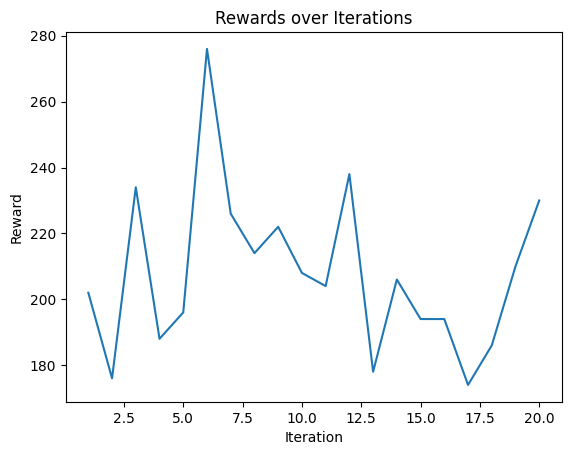

  Unseen Data    Model Output
0    continue  move_down_left


In [ ]:
output = test_ReinforcementLearning()

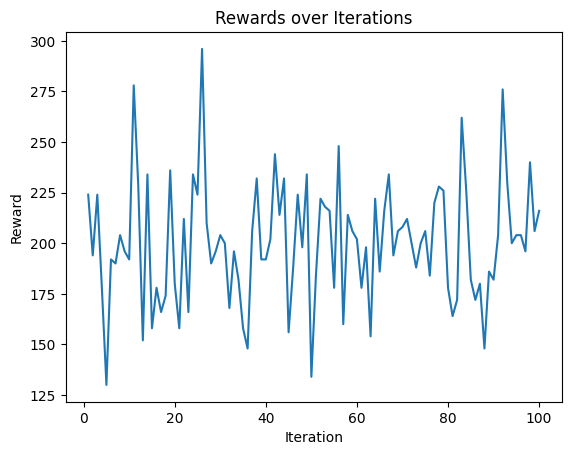

Max Reward : 296
Max reward Policy_set:  {'continue': 'move_down_right', 'hit_target': 'straight'}
Last iteration Policy :  {'hit_target': 'straight', 'continue': 'straight'}


In [ ]:
model_new = test_PolicyUpdating()

In [ ]:
model_new['Policy']

{'hit_target': 'straight', 'continue': 'straight'}

In [ ]:
output['Model Output']

0    move_down_left
Name: Model Output, dtype: object

# New Section